<a href="https://colab.research.google.com/github/AbhiDhariwal/Machine-Learning/blob/master/LIME_Explaining_Inception_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import decode_predictions
import os
import pickle


from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()


class InceptionV3():
    def __init__(self, model_dir=None):
        self.model_dir = model_dir
        self.IMG_SIZE = 299
        self.BATCH_SIZE = 32
        self.SHUFFLE_BUFFER_SIZE = 1000
        self.learning_rate = 0.0001
        self.model = None

        # Load Model
        if self.model_dir is None:
            self.model = self._get_pretrained_model()
            self.model_dir = './model/inceptionv3_model'
        else:
            try:
                self.model = tf.keras.models.load_model(model_dir)
            except:
                raise NameError("Model not found")

    @staticmethod
    def _get_pretrained_model():
        base_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
        # base_model.trainable = False
        # pool_layer = tf.keras.layers.GlobalAveragePooling2D()
        # out_layer = tf.keras.layers.Dense(100)
        # model = tf.keras.Sequential([base_model, pool_layer, out_layer])
        # return model
        return base_model

    def train(self, dataset, epochs):
        """
        Train model
        @param dataset: data.Data object
        @return:
        """
        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=self.learning_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        self.model.fit(dataset.train_data, epochs=epochs)
        loss, accuracy = self.model.evaluate(dataset.train_data)
        print("Loss :", loss)
        print("Accuracy :", accuracy)

    def predict(self, image):
        return self.model.predict(image)

    def decode_predict(self, prediction):
        return decode_predictions(prediction)


In [ ]:
pip install lime

     |████████████████████████████████| 276kB 5.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=ad9edec78726c974dd8ddd76a84a0a90e256e81d2f6bc21cd622b4669fe44782
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [25]:
import os, sys
import linecache
import urllib.request
import numpy as np
import argparse
import time
import matplotlib
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from lime import lime_image
from tensorflow.keras.applications.inception_v3 import preprocess_input as prepro_inp
from tensorflow.keras.preprocessing import image


# from .common.data import Dataset

def get_imagenet_to_label():
    imagenet_code_to_label = {}
    try:
        with open("./imagenet_to_label.txt") as f:
            lines = f.readlines()
    except FileNotFoundError:
        with open("imagenet_to_label.txt") as f:
            lines = f.readlines()

    for line in lines:
        temp = line.replace('{', '').replace('}', '').split(':')
        imagenet_code_to_label[int(temp[0])] = temp[1].replace('\'', '').strip()
    return imagenet_code_to_label

def get_model(test_image_path):
    my_model = InceptionV3()
    img = image.load_img(test_image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = prepro_inp(x)
    x = np.vstack([x])

    return x[0], my_model


def predict(test_image_path):
    my_model = InceptionV3()
    # my_model.model.summary()
   
    img = image.load_img(test_image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = prepro_inp(x)
    x = np.vstack([x])

    prediction = my_model.predict(x)

    return x, my_model.decode_predict(prediction), my_model


def explain(image, my_model, prediction_rank=0, show_img=True):
    start = time.time()
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(image, my_model.predict, top_labels=5, hide_color=0, num_samples=1000)
    # print(explanation)

    decoder = get_imagenet_to_label()
    print(explanation.top_labels[prediction_rank], decoder[explanation.top_labels[prediction_rank]])

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[prediction_rank], positive_only=False,
                                                num_features=5,
                                                hide_rest=False)  # num_features is top super pixel that gives positive value

    print("Explanation time", time.time() - start)
    if show_img:
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()
    masked_image = mark_boundaries(temp / 2 + 0.5, mask)
    return masked_image


In [ ]:

# # Referencing lime: https://github.com/marcotcr/lime


In [27]:
!wget https://gist.githubusercontent.com/AbhiDhariwal/c0695210faa86ca70b05ed4bd0cee5e0/raw/f6eb88df35764be4aac8688a22a236e0fd3ba141/imagenet_to_label.txt

--2020-11-24 08:24:52--  https://gist.githubusercontent.com/AbhiDhariwal/c0695210faa86ca70b05ed4bd0cee5e0/raw/f6eb88df35764be4aac8688a22a236e0fd3ba141/imagenet_to_label.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet_to_label.txt’

imagenet_to_label.t 100%[===================>]  29.85K  --.-KB/s    in 0.002s  

2020-11-24 08:24:52 (13.0 MB/s) - ‘imagenet_to_label.txt’ saved [30564/30564]



In [ ]:

if not os.path.isdir("./data/test/"):
    os.makedirs("./data/test/")
urllib.request.urlretrieve("https://images-na.ssl-images-amazon.com/images/I/711JIPAuVhL._SL1500_.jpg",
                            "./data/test/car_01.jpg")
test_image_path = "./data/test/car_01.jpg"


In [ ]:

print("Using file from {}".format(test_image_path))
images, prediction, my_model = predict(test_image_path)
print("Decoding")
print(prediction)


Intercept -0.01321119055539078
Prediction_local [0.03598659]
Right: 0.03556038
Intercept -0.19279896075785657
Prediction_local [0.42264628]
Right: 0.036733475
Intercept -0.023659419907957085
Prediction_local [0.10024525]
Right: 0.038200743
Intercept -0.006648044902828472
Prediction_local [0.00971774]
Right: 0.05855978
Intercept -0.0304843281212981
Prediction_local [0.04269737]
Right: 0.1591744
859 toaster,
Explanation time 210.05443382263184


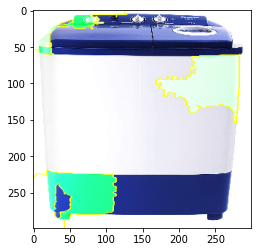

In [ ]:

a = explain(images[0], my_model, show_img=True)


Intercept -0.015018118682160811
Prediction_local [0.0346072]
Right: 0.03556038
Intercept -0.19720295384732112
Prediction_local [0.39805875]
Right: 0.036733475
Intercept -0.023798153916383222
Prediction_local [0.12064041]
Right: 0.038200743
Intercept -0.006605244528900727
Prediction_local [0.00997087]
Right: 0.05855978
Intercept -0.024320732219184613
Prediction_local [0.03387007]
Right: 0.1591744
897 washer, automatic washer, washing machine,
Explanation time 214.3389310836792


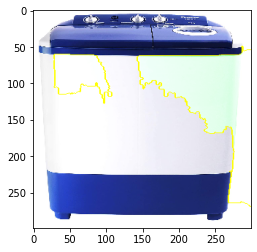

In [ ]:


a = explain(images[0], my_model, show_img=True,prediction_rank=1)

### Explaination 

In [24]:
url_list = [
            "https://images-na.ssl-images-amazon.com/images/I/61F91pD42cL._SL1500_.jpg",
            "https://images-na.ssl-images-amazon.com/images/I/71cFxsy%2BBCL._SL1500_.jpg",
            "https://images-na.ssl-images-amazon.com/images/I/51TDncaFsQL._SL1000_.jpg",
            "https://images-na.ssl-images-amazon.com/images/I/41enYR2r3aL.jpg",
            "https://images-na.ssl-images-amazon.com/images/I/81z6VhScaTL._SL1500_.jpg"
]


if not os.path.isdir("./data/test/"):
    os.makedirs("./data/test/")

for i,url in enumerate(url_list):
    urllib.request.urlretrieve(url,
                            "./data/test/image{0}.jpg".format(i))


Using file from ./data/test/image0.jpg

-------------Predictions-------------
[[('n04554684', 'washer', 0.8887934), ('n04069434', 'reflex_camera', 0.0015698753), ('n03692522', 'loupe', 0.0010318274), ('n03207941', 'dishwasher', 0.0009333414), ('n04009552', 'projector', 0.00065894116)]]
Explaination of predition 0



Intercept 0.024429510267819265
Prediction_local [-0.0111162]
Right: 0.0006589408
Intercept 0.006625097157497239
Prediction_local [0.00033828]
Right: 0.000933341
Intercept 0.251236341841721
Prediction_local [-0.12850513]
Right: 0.0010318259
Intercept 0.029207492635967544
Prediction_local [-0.00111803]
Right: 0.0015698732
Intercept -0.16875694352017
Prediction_local [1.38588123]
Right: 0.8887934
897 washer, automatic washer, washing machine,
Explanation time 211.50068426132202


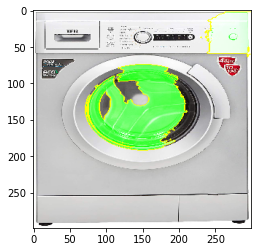

Explaination of predition 1


KeyboardInterrupt: ignored

In [26]:
for i in range(5):
    test_image_path = "./data/test/image{}.jpg".format(i)
    print("Using file from {}".format(test_image_path))
    images, prediction, my_model = predict(test_image_path)
    print("\n-------------Predictions-------------")
    print(prediction)
    for index in range(5):
        print("\n ------------Explaination of predition",index,"-------------------")
        a = explain(images[0], my_model, show_img=True,prediction_rank=index)
